In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scikits.odes.ode import ode
import time
import random

In [2]:
#Import local functions
sys.path.append('../functions')
from functions import nonlinearity, repression, activation

In [13]:
def solve_point(x, func):
    n1, n2, theta1, theta2, k1, k2 = x
    
    alpha1 = 1E-5
    alpha2 = 1E-2

    int_time = 5E4
    t = np.linspace(0, int_time, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.]) 

    def dual_control_sundials(t, y, ydot):
        kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
        ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

    def upstream_repression_sundials(t, y, ydot):
        kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
        ydot[3] = k2 - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = repression(y[1], k1, theta1, n1)
    
    def downstream_activation_sundials(t, y, ydot):
        kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = k1 - lam*y[2]
        ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = activation(y[1], k2, theta2, n2)

    def loss_biological(j1, j2, alpha1, alpha2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

    if func == 'dc':
        solution = ode('cvode', dual_control_sundials, old_api=False).solve(t, y0)
    elif func == 'ur':
        solution = ode('cvode', upstream_repression_sundials, old_api=False).solve(t, y0)
    elif func == 'da':
        solution = ode('cvode', downstream_activation_sundials, old_api=False).solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=alpha1, alpha2=alpha2)
    return loss

In [14]:
def solve_patch_6d(init_conds, patch_size, step_sizes, func):
    n1, n2, theta1, theta2, k1, k2 = init_conds
    center_loss = solve_point(init_conds, func)
    #Sample randomly from hypersphere
    normal_deviates = np.random.normal(size=(6, patch_size))
    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    points = normal_deviates/radius

    scaled_points = []
    for i in range(patch_size):
        scaled_points.append(list(step_sizes*points[:, i]  + init_conds))
    scaled_points = np.array(scaled_points)
    
    min_loss = center_loss
    new_k1 = k1; new_k2 = k2; new_theta1 = theta1; new_theta2 = theta2; new_n1 = n1; new_n2 = n2
    for n1, n2, theta1, theta2, k1, k2 in zip(scaled_points[:, 0], scaled_points[:, 1], scaled_points[:, 2], scaled_points[:, 3], scaled_points[:, 4], scaled_points[:, 5]):
        loss = solve_point([n1, n2, theta1, theta2, k1, k2], func)
        if bounds_check_6d(n1, n2, theta1, theta2, k1, k2):
            if loss < min_loss:
                new_k1 = k1
                new_k2 = k2
                new_theta1 = theta1
                new_theta2 = theta2
                new_n1 = n1
                new_n2 = n2
                min_loss = loss
    return new_n1, new_n2, new_theta1, new_theta2, new_k1, new_k2, min_loss

In [15]:
def bounds_check_6d(n1, n2, theta1, theta2, k1, k2):
    if k1 <= 1E-3 and k2 <= 1E-3 and k1 >= 1E-7 and k2 >= 1E-7:
        if n1 <= 4 and n2 <= 4 and n1 >= 1 and n2 >= 1:
            if theta1 >= 0.001 and theta2 >= 0.001 and theta1 <= 10 and theta2 <= 10:
                return True
    else: return False

In [19]:
def gen_ics(N):
    #Set random seed
    np.random.seed(2022)
    ics = []
    for i in range(N):
        k1 = random.uniform(1E-7,1E-3)
        k2 = random.uniform(1E-7,1E-3)
        n1 = random.uniform(1,4)
        n2 = random.uniform(1,4)
        theta1 = random.uniform(0.001,10)
        theta2 = random.uniform(0.001,10)

        init_conds = np.array([n1,n2,theta1, theta2, k1, k2])
        ics.append(init_conds)
    return ics

#Randomize N=10 initial conditions 
ics = gen_ics(10)

In [23]:
#Set hyperparameters
num_epochs = 100
tolerance = 0.0004
patch_size = 100
step_sizes = np.array([0.1, 0.1, 0.01, 0.01, 0.0001, 0.0001])
list_of_results = []
func='dc'
for i in range(len(ics)):
    print('Descent', i+1, 'of', len(ics))
    init_conds = ics[i]
    solve_patch_6d(init_conds, patch_size, step_sizes, func)
    next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2, loss = solve_patch_6d(init_conds, patch_size, step_sizes, func)

    losses = [loss]; k1_trace = [next_k1]; k2_trace = [next_k2]; n1_trace = [next_n1]; n2_trace = [next_n2]; theta1_trace = [next_theta1]; theta2_trace = [next_theta2]

    for i in range(num_epochs):
        new_n1, new_n2, new_theta1, new_theta2, new_k1, new_k2, loss = solve_patch_6d([next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2], patch_size, step_sizes, func)
        next_k1 = new_k1
        next_k2 = new_k2
        next_theta1 = new_theta1
        next_theta2 = new_theta2
        next_n1 = new_n1
        next_n2 = new_n2

        print('Epoch: ', i, 'Loss: ', loss)
        losses.append(loss)
        k1_trace.append(new_k1)
        k2_trace.append(new_k2)
        n1_trace.append(new_n1)
        n2_trace.append(new_n2)
        theta1_trace.append(new_theta1)
        theta2_trace.append(new_theta2)

        if losses[-2] - losses[-1] < tolerance:
            print('Terminating early at step', i, 'of ', num_epochs)
            break
    results = pd.DataFrame({'loss':losses,'k1_trace':k1_trace,'k2_trace':k2_trace,'n1_trace':n1_trace,'n2_trace':n2_trace,'theta1_trace':theta1_trace, 'theta2_trace':theta2_trace})
    list_of_results.append(results)
list_of_results_dc = list_of_results

Descent 1 of 10
Epoch:  0 Loss:  10.299552829900245
Epoch:  1 Loss:  2.2262894001952636
Epoch:  2 Loss:  0.04278284498922865
Epoch:  3 Loss:  0.04278284498922865
Terminating early at step 3 of  100
Descent 2 of 10



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.0699599685833964
Terminating early at step 0 of  100
Descent 3 of 10



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  0 Loss:  19.843759590926688
Epoch:  1 Loss:  7.611199160922034
Epoch:  2 Loss:  0.19336114180731323



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.06838940383195981



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.06780454086757187



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.06724596050006212



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.06638647069804364



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  7 Loss:  0.06638647069804364
Terminating early at step 7 of  100
Descent 4 of 10



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  0 Loss:  1.7096274053818261
Epoch:  1 Loss:  0.04220680457263526
Epoch:  2 Loss:  0.04218200087351148
Terminating early at step 2 of  100
Descent 5 of 10
Epoch:  0 Loss:  0.042524437955783034
Epoch:  1 Loss:  0.042359403113575216
Terminating early at step 1 of  100
Descent 6 of 10
Epoch:  0 Loss:  0.454402748156136
Epoch:  1 Loss:  0.4393098616881631
Epoch:  2 Loss:  0.4250280391652946
Epoch:  3 Loss:  0.40666762791193267
Epoch:  4 Loss:  0.38503428052881405
Epoch:  5 Loss:  0.360448289973705
Epoch:  6 Loss:  0.3349137102015652
Epoch:  7 Loss:  0.30440816918597535
Epoch:  8 Loss:  0.27255409737790165
Epoch:  9 Loss:  0.24193534368512676
Epoch:  10 Loss:  0.20768173669300077
Epoch:  11 Loss:  0.1697445663784799
Epoch:  12 Loss:  0.13637261099052664
Epoch:  13 Loss:  0.11147643738905996
Epoch:  14 Loss:  0.0953141199618622
Epoch:  15 Loss:  0.0904175568283909
Epoch:  16 Loss:  0.08603227870355358
Epoch:  17 Loss:  0.08193148698100716
Epoch:  18 Loss:  0.07851474361139893
Epoch:  


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  0 Loss:  0.06494680425926508



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  1 Loss:  0.06276208083666328



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  2 Loss:  0.06157600406440279



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  3 Loss:  0.06077125421744244



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  4 Loss:  0.057806051778628076



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  5 Loss:  0.055667913974598124



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  6 Loss:  0.05270693849365954



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



Epoch:  7 Loss:  0.04908993173288753
Epoch:  8 Loss:  0.04703751672297411
Epoch:  9 Loss:  0.045309976091167145
Epoch:  10 Loss:  0.045309976091167145
Terminating early at step 10 of  100


In [24]:
true_landscape = pd.read_csv('../6d_loss_landscape/ur_landscape_sundials.csv')

landscape = true_landscape.loc[true_landscape.theta1 != 100].loc[true_landscape.theta2 != 100]
min_loss = landscape.loss.min()
tolerance = 0.04

low_loss_ur = landscape.loc[landscape.loss < min_loss + tolerance]

true_landscape = pd.read_csv('../6d_loss_landscape/da_landscape_sundials.csv')
landscape = true_landscape.loc[true_landscape.theta1 != 100].loc[true_landscape.theta2 != 100]
min_loss = landscape.loss.min()
low_loss_da = landscape.loc[landscape.loss < min_loss + tolerance]

true_landscape = pd.read_csv('../6d_loss_landscape/6d_landscape_sundials.csv')
landscape = true_landscape.loc[true_landscape.theta1 != 100].loc[true_landscape.theta2 != 100]
min_loss = landscape.loss.min()
low_loss_dc = landscape.loc[landscape.loss < min_loss + tolerance]


In [25]:

ci_losses = []
ci_epochs = []
for df in list_of_results_ur: 
    loss = df.loss.to_list()
    epochs = df.index.to_list()
    ci_losses = ci_losses + loss
    ci_epochs = ci_epochs + epochs
ci_df_ur = pd.DataFrame({'loss': ci_losses, 'epoch':ci_epochs})


ci_losses = []
ci_epochs = []
for df in list_of_results_dc: 
    loss = df.loss.to_list()
    epochs = df.index.to_list()
    ci_losses = ci_losses + loss
    ci_epochs = ci_epochs + epochs
ci_df_dc = pd.DataFrame({'loss': ci_losses, 'epoch':ci_epochs})


ci_losses = []
ci_epochs = []
for df in list_of_results_da: 
    loss = df.loss.to_list()
    epochs = df.index.to_list()
    ci_losses = ci_losses + loss
    ci_epochs = ci_epochs + epochs
ci_df_da = pd.DataFrame({'loss': ci_losses, 'epoch':ci_epochs})


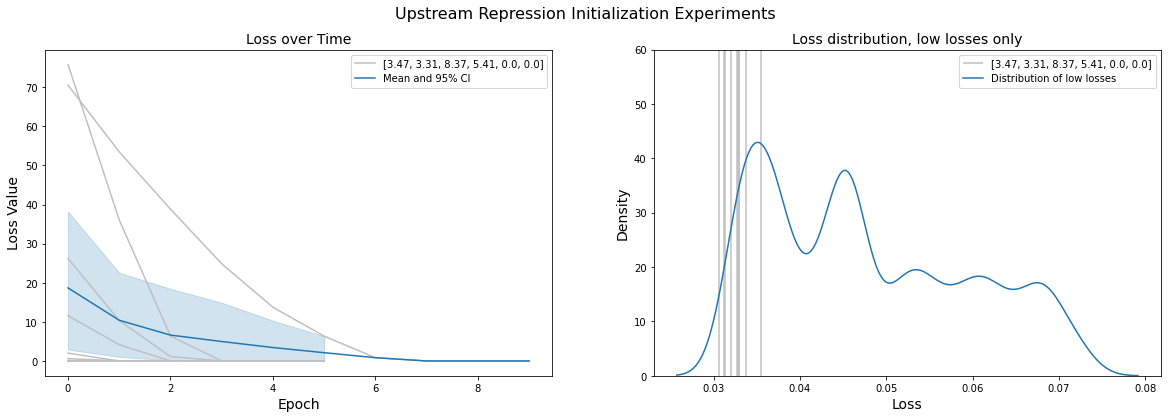

In [35]:
list_of_results = list_of_results_ur
ci_df = ci_df_ur
low_loss = low_loss_ur
suptitle = 'Upstream Repression Initialization Experiments'

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

endpoint = 'Loss over Time'
ax = axs[0]
for i in range(len(list_of_results)): 
    df = list_of_results[i]
    if i % 10 == 0:
        ax.plot(df.loss, color='silver', label=str(list(np.around(ics[i],2))))
    else: 
        ax.plot(df.loss, color='silver')
sns.lineplot(data=ci_df, x="epoch", y="loss", label='Mean and 95% CI',ax=ax)
ax.legend()
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)


endpoint = 'Loss distribution, low losses only'
ax = axs[1]
for i in range(len(list_of_results)): 
    df = list_of_results[i]
    if i % 10 == 0:
        ax.vlines(df.loss.to_list()[-1], 0, 200, color='silver', label=str(list(np.around(ics[i],2))))
    else: 
        ax.vlines(df.loss.to_list()[-1], 0, 200, color='silver')
    
sns.kdeplot(low_loss.loss, ax=ax, label='Distribution of low losses')

ax.set_ylim([0, 60])
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Loss', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
fig.suptitle(suptitle, fontsize=16)
fig.savefig('init_losses_ur.png')


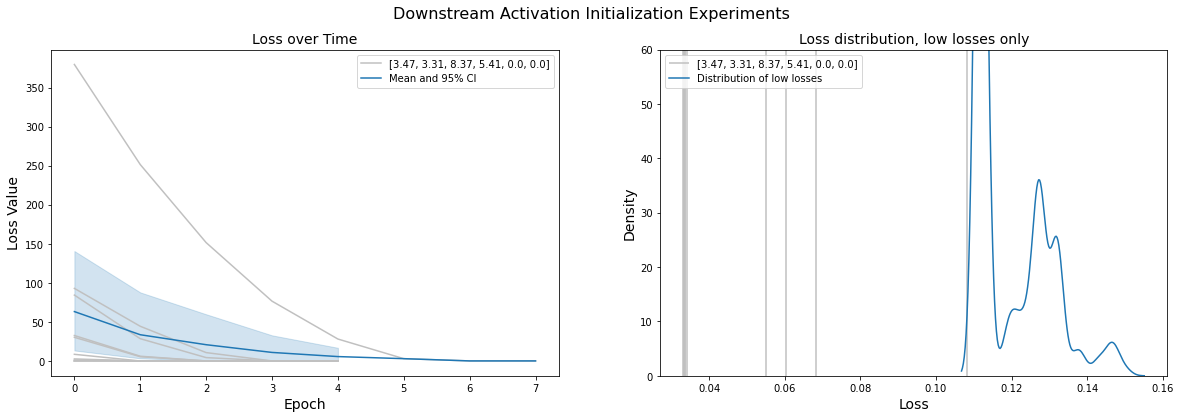

In [36]:
list_of_results = list_of_results_da
ci_df = ci_df_da
low_loss = low_loss_da
suptitle = 'Downstream Activation Initialization Experiments'

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

endpoint = 'Loss over Time'
ax = axs[0]
for i in range(len(list_of_results)): 
    df = list_of_results[i]
    if i % 10 == 0:
        ax.plot(df.loss, color='silver', label=str(list(np.around(ics[i],2))))
    else: 
        ax.plot(df.loss, color='silver')
sns.lineplot(data=ci_df, x="epoch", y="loss", label='Mean and 95% CI',ax=ax)
ax.legend()
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)


endpoint = 'Loss distribution, low losses only'
ax = axs[1]
for i in range(len(list_of_results)): 
    df = list_of_results[i]
    if i % 10 == 0:
        ax.vlines(df.loss.to_list()[-1], 0, 200, color='silver', label=str(list(np.around(ics[i],2))))
    else: 
        ax.vlines(df.loss.to_list()[-1], 0, 200, color='silver')
    
sns.kdeplot(low_loss.loss, ax=ax, label='Distribution of low losses')

ax.set_ylim([0, 60])
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Loss', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
fig.suptitle(suptitle, fontsize=16)
fig.savefig('init_losses_da.png')


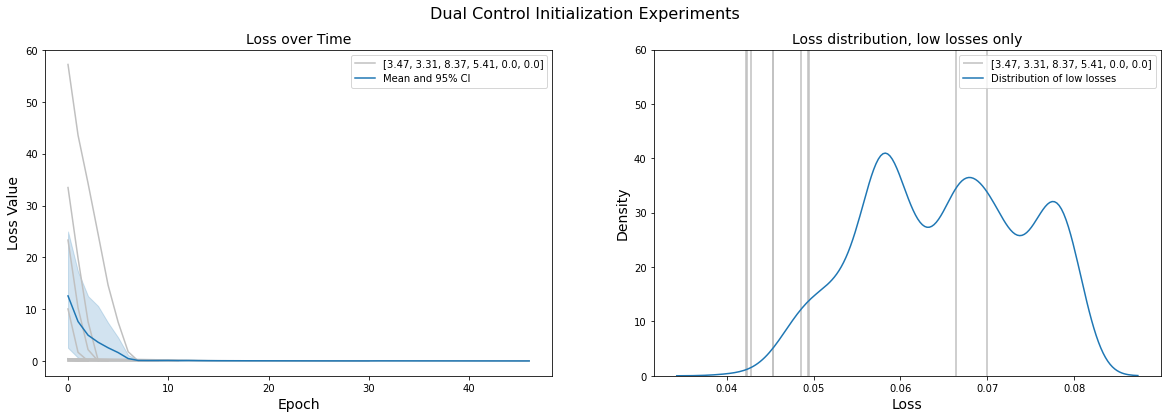

In [39]:
list_of_results = list_of_results_dc
ci_df = ci_df_dc
low_loss = low_loss_dc
suptitle = 'Dual Control Initialization Experiments'

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

endpoint = 'Loss over Time'
ax = axs[0]
for i in range(len(list_of_results)): 
    df = list_of_results[i]
    if i % 10 == 0:
        ax.plot(df.loss, color='silver', label=str(list(np.around(ics[i],2))))
    else: 
        ax.plot(df.loss, color='silver')
sns.lineplot(data=ci_df, x="epoch", y="loss", label='Mean and 95% CI',ax=ax)
ax.legend()
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)


endpoint = 'Loss distribution, low losses only'
ax = axs[1]
for i in range(len(list_of_results)): 
    df = list_of_results[i]
    if i % 10 == 0:
        ax.vlines(df.loss.to_list()[-1], 0, 200, color='silver', label=str(list(np.around(ics[i],2))))
    else: 
        ax.vlines(df.loss.to_list()[-1], 0, 200, color='silver')
    
sns.kdeplot(low_loss.loss, ax=ax, label='Distribution of low losses')

ax.set_ylim([0, 60])
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Loss', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
fig.suptitle(suptitle, fontsize=16)
fig.savefig('init_losses_dc.png')


In [42]:
final_losses = pd.DataFrame()
final_losses_dc = []; final_losses_ur = []; final_losses_da = []; 
for i in range(len(list_of_results)):
    dc = list_of_results_dc[i]
    final_losses_dc.append(dc.loss.to_list()[-1])

    ur = list_of_results_ur[i]
    final_losses_ur.append(ur.loss.to_list()[-1])

    da = list_of_results_da[i]
    final_losses_da.append(da.loss.to_list()[-1])
final_losses['da'] = final_losses_da
final_losses['ur'] = final_losses_ur
final_losses['dc'] = final_losses_dc

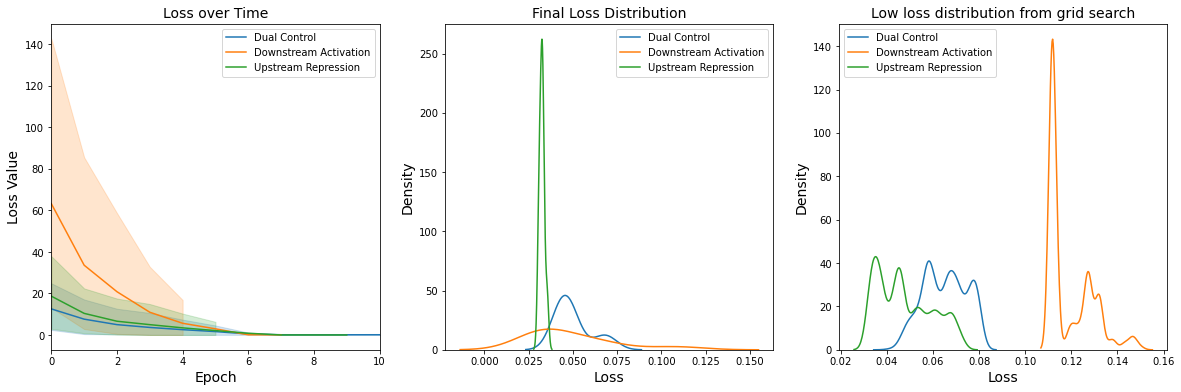

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

endpoint = 'Loss over Time'
ax = axs[0]
sns.lineplot(data=ci_df_dc, x="epoch", y="loss", label='Dual Control',ax=ax)
sns.lineplot(data=ci_df_da, x="epoch", y="loss", label='Downstream Activation',ax=ax)
sns.lineplot(data=ci_df_ur, x="epoch", y="loss", label='Upstream Repression',ax=ax)

ax.legend()
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_xlim([0, 10])

endpoint = 'Final Loss Distribution'
ax = axs[1]
    
sns.kdeplot(final_losses.dc, ax=ax, label='Dual Control')
sns.kdeplot(final_losses.da, ax=ax, label='Downstream Activation')
sns.kdeplot(final_losses.ur, ax=ax, label='Upstream Repression')


ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Loss', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()

endpoint = 'Low loss distribution from grid search'
ax = axs[2]


sns.kdeplot(low_loss_dc.loss, label='Dual Control')
sns.kdeplot(low_loss_da.loss, label='Downstream Activation')
sns.kdeplot(low_loss_ur.loss, label='Upstream Repression')
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Loss', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()

fig.savefig('final_loss_dist.png')
